# Lecture #5: Sampling for Posterior Simulation
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2020

<img src="fig/logos.jpg" style="height:150px;">

In [2]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Outline
1. Basics of Sampling
2. Inverse CDF Sampling
3. Rejection Sampling
4. Gibbs Sampling

# Basics of Sampling

## Motivation

Note that nearly *every* computation for Bayesian models requires us being able to obtain samples from the posterior:

1. Generating synethtic data from the posterior predictive require us to sample from the model parameters from the posterior, and then sample data given each of these parameters samples.

2. Empirically computing the posterior predictive mean requires samples from the posterior.

3. Evaluating the fit of the Bayesian model, i.e. empirically computing the marginal data log-likelihood, requires us to average the likelihood of the data over parameter samples from the posterior.

This is why Bayesian inference relies crucially on the tractability of the posterior. And yet, the posterior of most Bayesian models do not have nice simple closed forms! So how to we sample from these posteriors?

## What is Sampling?

Given a distribution $p(x)$ over a space $\mathbb{R}^D$, ***sampling*** $x \sim p(x)$ means to generate a random $x\in \mathbb{R}^D$, such that the asymptotic frequencies of the samples generated is described by the pdf $p(x)$.

A ***sampler*** is an algorithm or procedure that produces numbers with a certain distribution $p(x)$.

In practice, "random numbers" are simulated using deterministic algorithms called ***pseudo number generators***. A pseudo number generator takes an initial value, the ***random seed***, and produces an array of random looking numbers (from a uniform distribution).

**Note:** for a given pseudo number generator, if the random seed is fixed then the random number output will also be fixed.

## Simulating a Uniform Random Variable: Linear Congruence

Fix an integer $c > N$ and fix integers $a, b > 0$. 
1. seed: set an integer $0\leq s_0 < c$
2. iterate $N$ times: $$s_n = (as_{n-1} + b)_{\text{mod } c}$$

Output is an array of random integers $[s_0, \ldots, s_N]$ in $[0, c]$. 

For an array of random real numbers in $[0, 1]$, we compute $\left[\frac{s_0}{c}, \ldots, \frac{s_N}{c}\right]$. 

We'll see that **the simulation of all random variables is based on the simulation of the uniform distribution over $[0, 1]$**!

**Note:** the apparent randomness of the output is sensitive to choices of $a, b, c$.

In [2]:
#parameters of linear congruence algorithm
c = 100
a = 11
b = 5
#total number of simulations
N = 10
#random seed
s_current = 3
#array of random numbers
random_numbers = []

#run the linear congruence algorithm N times
for n in range(N):
    s_next = (a * s_current + b) % c
    random_numbers.append(s_next)
    s_current = s_next
    
#convert random integers to random real values in [0, 1]    
random_numbers = np.array(random_numbers) * 1.
random_numbers /= c
#print
random_numbers

array([0.38, 0.23, 0.58, 0.43, 0.78, 0.63, 0.98, 0.83, 0.18, 0.03])

# Inverse CDF Sampling

## The Cumulative Distribution Function

Recall that the ***cumulative distribution function (CDF)*** of a real-valued random variable $X$ with continuous pdf $f_X$ is defined as
$$
F_X(a) = \mathbb{P}[X \leq a] = \int_{-\infty}^a f_X(t) dt
$$
<img src="fig/cdf.jpg" style="height:300px">

## Inverse CDF Sampling: An Intuition
The idea behind Inverse CDF Sampling is that while it is sometimes difficult to generate values for $X$ with the relative frequency described by pdf, $f_X$, it can be easier to generate values for $X$ using the CDF. 

The intuition is as follows:

1. While the support of the pdf and CDF can be unbounded, the range of the CDF is bounded between 0 and 1.<br><br>
2. The CDF for a continuous single-variable pdf is an invertible function (on the support of the pdf). That is, each value between 0 and 1 corresponds to a unique value of the random variable $X$.<br><br>
3. Values of $X$ that lie under peaks of the pdf occupy larger portions of the interval [0, 1]. That is, the range of the CDF, [0, 1], can be subdivided to exactly reflect the areas of high probability mass and low probability mass under the pdf. 

So if we uniformly sample values in the range of the CDF, [0, 1] and find the corresponding $X$ values for these samples (using the inverse function of the CDF), we obtain samples of $X$. 

## Inverse CDF Sampling: An Intuition
<img src="fig/inverse_cdf.jpg" style="height:350px">

## Inverse CDF Sampling: Algorithm

We use a random variable $U$ with uniform distribution over $[0, 1]$ to simulate a univariate random variable $X$ with pdf $f_X$, where:
- we know the analytical form of the CDF of $X$, $F_X$.
- we know the analytical form of the inverse of the CDF of $X$, $F^{-1}_X$.

To simulate $X$, we repeat for $N$ number of samples:
1. sample 
$$U_n \sim U(0, 1)$$
2. compute 
$$X_n = F^{-1}_X(U_n)$$

**Question:** How do we simulate multivariate random variables? What if we don't have the analytical form of $F^{-1}_X$?

## Inverse CDF Sampling: Proof of Correctness

**Theorem:**  Let $F_X$ be the continuous and strictly increasing CDF of a real-valued random variable $X$. Let $F_X^{−1} : [0,1] \to \mathbb{R}$ be the inverse function of $F_X$. Let $U \sim U(0,1)$, then the random variable $Y = F_X^{−1}(U)$ has CDF $F_X$.

***Proof:*** Recall that the CDF of $Y$ is defined by $F_Y(x) = \mathbb{P}[Y \leq x]$. Now, we can write

\begin{aligned}
F_Y(x) &= \mathbb{P}[Y \leq x]&\\ 
&= \mathbb{P}[F_X^{−1}(U) \leq x],&(\text{since $Y = F_X(U)$})\\
&= \mathbb{P}[F_X(F_X^{−1}(U)) \leq F_X(x)],&(\text{since $F_X$ is strictly increasing})\\
&= \mathbb{P}[U \leq F_X(x)],&(\text{since $F_X^{-1}$ is the inverse of $F_X$})\\
&= F_X(x)& (\text{since $0\leq F_X\leq 1$})
\end{aligned}

## Simulating an Exponential Random Variable
We'll use a uniform random variable $U\sim U(0, 1)$ to simulate a exponential variable $X\sim Exp(\lambda)$. Recall that the exponential CDF is
$$
F_X(x) = 1 - e^{-\lambda x}.
$$

The inverse of the CDF can be found by solving for the input, $x$, of the CDF
\begin{aligned}
y &= 1 - e^{-\lambda x}\\
e^{-\lambda x} &= 1 - y\\
-\lambda x &= \log(1 - y)\\
x &= -\frac{1}{\lambda}\log(1 - y)
\end{aligned}
where we take $\log$ to be base $e$.

Thus, $F_X^{-1}(y) = -\frac{1}{\lambda}\log(1 - y)$.

In [3]:
N = 500
lam = 0.5
#get the exponential pmf function from scipy.stats
exp_pmf = sp.stats.expon(scale=1./lam).pdf
#inverse cdf of exponential
inverse_cdf = lambda y: -1. / lam * np.log(1 -  y)
#inverse cdf samples
U = np.random.uniform(0, 1, size=N)
samples = inverse_cdf(U)

## Simulating an Exponential Random Variable

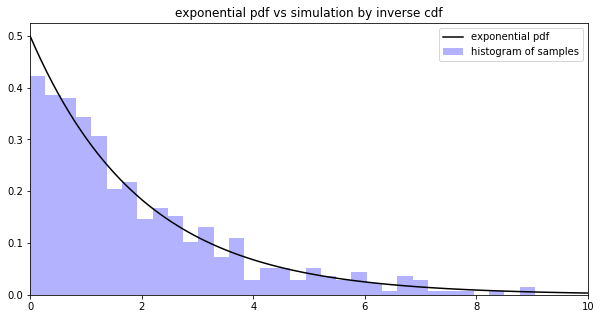

In [4]:
#plot true pdf and samples
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 100)
ax.plot(x, exp_pmf(x), color='black', label='exponential pdf')
ax.hist(samples, bins=50, density=True, color='blue', alpha=0.3, label='histogram of samples')
ax.set_title('exponential pdf vs simulation by inverse cdf')
ax.set_xlim([0, 10])
ax.legend(loc='best')
plt.show()   

## Simulating a Bernoulli Random Variable

The CDF of a discrete random variable $X$ with $K$ possible outputs is a step function:

<img src="fig/bernoulli_cdf.jpg" style="height:350px">

Technically this CDF is not invertible. But we can easily map the output of the CDF to values of $X$. The CDF naturally divides the interval [0, 1] into $K$ parts, each part should be mapped to a case where $X=k$. For example, the Bernoulli CDF divides up the interval into two parts, the first $[0, 1-\theta]$ maps to naturally to $X=0$ and the second $[0, 1-\theta]$ maps to $X=1$.

Thus, to simulate a Bernoulli random variable $X \sim Ber(\theta)$, we
1. sample $U\sim U(0, 1)$
2. if $U<1-\theta$ we map to $X=0$, otherwise we map to $X=1$

This process is easily extended to categorical variables with $K$ categories.

In [5]:
#Bernoulli distribution
theta = 0.6
#number of samples
N = 500

#simulate N number of uniform RVs
u = np.random.uniform(0, 1, size=N)
#for each uniform sample, determine if it is heads or tails by comparing to theta
heads = u < theta
tails = u >= theta
u[heads] = 1
u[tails] = 0

## Simulating a Bernoulli Random Variable

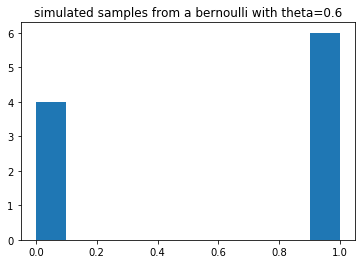

In [6]:
#plot samples
plt.hist(u, density=True)
plt.title('simulated samples from a bernoulli with theta={}'.format(theta))
plt.show()    

## What Can We Simulate?

We can simulate sampling from univariate continuous distributions with closed form inverse CDF's, e.g. exponential random variables. We can't simulate normal random variables since **the normal CDF does not have a closed form inverse**! We can't simulate multivariate random variables.

We can simulate discrete random variables.

# Rejection Sampling

## Rejection Sampling: An Intuition
The idea behind Rejection Sampling is to by-pass the problem of sampling from a difficult distribution $f_X$, by:

1. approximating $f_X$ (called the ***target distribution***), with a pdf $g$ (called the ***proposal distribution***) that is easy to sample
2. sample from $g$ and reject the samples that are unlikely to be from $f_X$


<img src="fig/rejection.jpg" style="height:350px">

## Rejection Sampling: Algorithm

We can use rejection sampling to simulate multivariate random variables and random variables for which we don't have a closed form for $F^{-1}_X$. We choose a proposal distribution $g$ such that (1) the support of $g$ covers the support of $f$ and (2) there is a constant $M > 0$ with $\frac{f_X(y)}{g(y)} \leq M$ for all $y$. 

In less high-falutin talk: we need (1) $g$ to be non-zero where ever $f$ is and $g$ must decay slower than $f$ (2) M * g is an upper bound of $f$.

To simulate $X$, we repeat until $N$ samples are accepted:
1. sample $Y_k \sim g(Y)$
2. sample a random height, $U_k \sim U(0, 1)$
3. if $U_k < \frac{f_X(Y_k)}{Mg(Y_k)}$ then accept $Y_k$ as a sample, else reject

**Question:** How long does it take to accumulate $N$ samples? What is the effect of the choice of the proposal distribution $g$ have on the sampling process? Now that we can sample from any distribution, this class is over right?

## Rejection Sampling: Proof of Correctness

We need to show that the accepted samples $Y$ have same distribution as $X$. In particular, we'll show that the CDF of the accepted samples is equal to $F_X$:
$$
\mathbb{P}\left[ Y \leq a\; \left\vert\; U \leq \frac{f_X(Y)}{Mg(Y)}\right. \right] = F_X(a).
$$
Using Baye's rule for probabilities, we get that
\begin{aligned}
\mathbb{P}\left[\left.U \leq \frac{f_X(Y)}{Mg(Y)} \; \right\vert\; Y \leq a  \right] &= \frac{\mathbb{P}\left[Y \leq a,\; U \leq \frac{f_X(Y)}{Mg(Y)} \right]}{\mathbb{P}\left[ Y \leq a\right]}\\
&= \int_{-\infty}^a \frac{\mathbb{P}\left[\left.U \leq \frac{f_X(Y)}{Mg(Y)} \; \right\vert\; Y \leq y \leq a  \right] g(y)}{\mathbb{P}\left[ Y \leq a\right]} dy\\
&= \frac{1}{\mathbb{P}\left[ Y \leq a\right]}\int_{-\infty}^a \mathbb{P}\left[\left.U \leq \frac{f_X(Y)}{Mg(Y)} \; \right\vert\; Y \leq y \leq a  \right] g(y) dy\\
&= \frac{1}{\mathbb{P}\left[ Y \leq a\right]} \int_{-\infty}^a \frac{f_X(y)}{Mg(y)} g(y) dy\\
&= \frac{1}{M\mathbb{P}\left[ Y \leq a\right]} \int_{-\infty}^a f_X(y) dy\\
&= \frac{1}{M\mathbb{P}\left[ Y \leq a\right]} \mathbb{P}\left[ X \leq a\right]\\
&= \frac{F_X(a)}{MG(a)}
\end{aligned}
where $G$ is the CDF of the proposal pdf $g$.

Now, we can write:
\begin{aligned}
\mathbb{P}\left[ Y \leq a\; \left\vert\; U \leq \frac{f_X(Y)}{Mg(Y)}\right. \right] &= \frac{\mathbb{P}\left[\left.U \leq \frac{f_X(Y)}{Mg(Y)} \; \right\vert\; Y \leq a  \right] \mathbb{P}\left[ Y \leq a\right]}{\mathbb{P}\left[U \leq \frac{f_X(Y)}{Mg(Y)}\right]}\\
&= \frac{\frac{F_X(a)}{MG(a)} * G(a)}{1/M}\\
&= F_X(a)
\end{aligned}
which is exactly what we wanted to show.

## Rejection Sampling: Efficiency

Given a proposal $Y=y$, the probability of accepting it is 
$$
\mathbb{P}\left[\left.U\leq \frac{f(Y)}{Mg(Y)} \right\vert Y=y\right] = \frac{f(y)}{Mg(y)}.
$$

So the overall probability $p$ of accepting any given proposal can be computed by integrating out $y$:

\begin{aligned}
p &= \int_{\mathbb{R}} \frac{f(y)}{Mg(y)} g(y)dy \\
&= \frac{1}{M} \int_{\mathbb{R}} f(y) dy\\
&= \frac{1}{M}
\end{aligned}

We see that the expected number of times it takes to draw and accept a sample $X=x$ is precisely $M$. This means that roughly $(M-1)/M$ of samples drawn from $g$ will be rejected. When $M$ is large, the rejection sampler is very inefficient.

## Simulating a Normal Random Variable

We note that if we can simulate a standard normal variable $X\sim \mathcal{N}(0, 1)$, then we can simulate any normal variable $Y\sim \mathcal{N}(\mu, \sigma^2)$ by setting $Y = \sigma* X + \mu$. 

We also observe that since the standard normal distirbution is symmetric about $X=0$, we only need to simulate samples from the non-negative side of $\mathcal{N}(0, 1)$ and then independently sample a sign (+ or -) for each sample using a Bernoulli distribution with $\theta = 0.5$. 

Simulating the positive half of the normal distribution means we need to scale the normal pdf by a factor of 2, so that is integrates to 1 over the nonnegative real numbers.

A natural candidate for a pdf to cover the non-negative half of the standard normal pdf is the exponential pdf.

In [4]:
#target distribution
target_pdf = sp.stats.norm(loc=0, scale=1).pdf
#proposal distirbution
proposal_pdf = sp.stats.expon(scale=1 / 0.5).pdf
#scaling constant
M = 2.

#total number of samples we want
N = 500
samples = []
#repeat rejection sampling until total number of samples is attained
while len(samples) < N:
    #sample x from proposal distribution
    proposed_sample = sp.stats.expon.rvs(scale=1 / 0.5, size=1)
    #sample a random height at x
    u = np.random.uniform(0, 1)
    #accept if height is below target distribution
    #remember that we are comparing the exponential distribution to the right half of the normal pdf
    #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
    if u < target_pdf(2 * proposed_sample) / (M * proposal_pdf(proposed_sample)):
        #if we are accepting randomly append a negative sign to the sample
        samples.append(proposed_sample * np.random.choice([-1, 1], size=1))
        
samples = np.array(samples)

## Simulating a Normal Random Variable

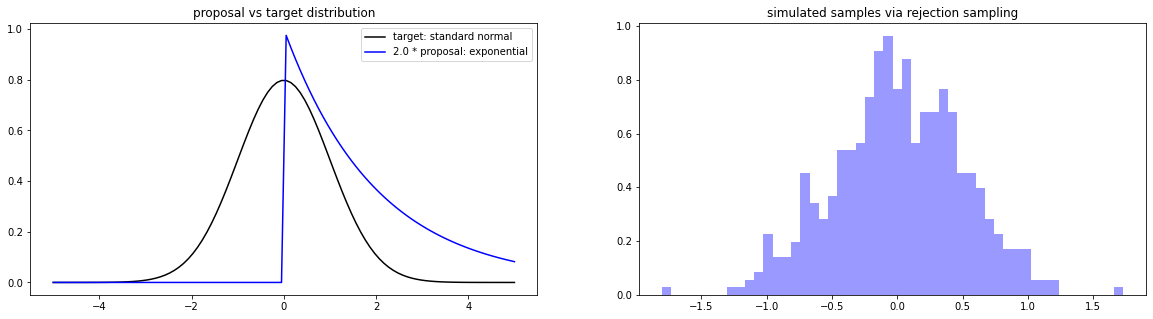

In [5]:
#plot samples
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-5, 5, 100)
ax[0].plot(x, 2 * target_pdf(x), color='black', label='target: standard normal')
ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: exponential'.format(M))
ax[0].set_title('proposal vs target distribution')
ax[0].legend(loc='best')
ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
ax[1].set_title('simulated samples via rejection sampling')
plt.show()   

## What Can We Simulate?

We can simulate any continuous or discrete random variable as long as we can find a suitable proposal distribution.

But as the dimensions of the random variable increases or for inappropriate choices of the proposal distribution, the efficiency of this sampler may be very low.

## Limitations of Rejection Sampling in High Dimensions

Since the acceptance rate for rejection sampling is 1/M, where $M$ is a constant that bounds $\frac{f_X(y)}{g(y)}$ for all $y$, we'd want to make $M$ as close to $1$ as possible, i.e. we want $g(y)$ to be approximately equal to $f_X(y)$. In general this is very difficult to achieve, especially in high dimensions.

**Example:**

Let's say our target distribution is a $D$-dimensional Gaussian $\mathcal{N}\left(0, \sigma_f^2\mathbf{I}_{D\times D}\right)$, where $\mathbf{I}_{D\times D}$ is a $D\times D$ identity matrix. Let's fix the proposal distribution to be a $D$-dimensional Gaussian $\mathcal{N}\left(0, \sigma_g^2\mathbf{I}_{D\times D}\right)$, where $\sigma_g > \sigma_f$. We can compute the optimum value of $M$ to be $\left(\frac{\sigma_g}{\sigma_f}\right)^D$. But this is a value that scales with $D$! For example, if $D=1,000$ and $\frac{\sigma_g}{\sigma_f} = 1.01$ then the probability of accepting a sample will be $\frac{1}{M} = 0.000047$.

# Gibbs Sampling

## Semi-Conjugate Priors

Let $Y \sim \mathcal{N}(\mu, \sigma^2)$, with both parameters unknown. We place a normal prior on $\mu$, $\mu\sim\mathcal{N}(m, s^2)$, and an gamma prior on $\sigma^2$, $\sigma^2\sim IG(\alpha, \beta)$.

The posterior $p(\mu, \sigma^2|Y)$ is then:

\begin{aligned}
p(\mu, \sigma^2 | Y)  = \frac{\overbrace{\frac{1}{\sqrt{2\pi \sigma^2}} \mathrm{exp} \left\{-\frac{(Y - \mu)^2}{2\sigma^2}\right\}}^{\text{likelihood}} \overbrace{\frac{1}{\sqrt{2\pi s^2}} \mathrm{exp} \left\{-\frac{(m - \mu)^2}{2s^2}\right\}}^{\text{prior on $\mu$}}\overbrace{\frac{\beta^\alpha}{\Gamma(\alpha)} \left( \sigma^2\right)^{-\alpha -1}\mathrm{exp} \left\{-\frac{\beta}{\sigma^2}\right\}}^{\text{prior on $\sigma^2$}}}{p(Y)}
\end{aligned}

Note that:

1. if we condition on $\sigma^2$ (i.e. hold it constant) then $p(\mu| Y, \sigma^2)$ is a normal pdf, $\mathcal{N}\left(\mu; \frac{s^2y + \sigma^2m}{s^2 + \sigma^2}, s^2\sigma^2\right)$.
2. if we condition on $\mu$ (i.e. hold it constant) then $p(\sigma^2| Y, \mu)$ is an inverse gamma pdf, $IG\left(\sigma^2; \alpha + 0.5, \frac{(y-\mu)^2}{2} + \beta\right)$

That is, **the conditional of the posterior are easy to sample from while the joint posterior is not**. In this case, we call the priors ***semi-conjugate*** for our likelihood.

## Gibbs Sampling: An Intuition
If we start at a point $(x^{(0)}, y^{(0)})$ sampled from from the joint distribution $p(X, Y)$, we can get to the next point $(x^{(1)}, y^{(1)}) \sim p(X, Y)$ through a "stepping-stone" $(x^{(1)}, y^{(0)})$, where we updated the first coordinate by $x^{(1)} \sim p(X|Y = y^{(0)})$. From there, we update the second coordinate $y^{(1)} \sim p(Y|X = x^{(1)})$.

The initial samples may be unlikely under $p(X, Y)$, but this process will eventually lead us to a high density area in $p(X, Y)$ and we will mostly sample there.
<img src="fig/gibbs.jpg" style="height:350px">

## Gibbs Sampling: Algorithm

To simulate $N$ samples of a $D$-dimensional multivariate random variable $X$ with pdf $f_X$, we
1. initialization: choose any $x^{(0)} = \left[x^{(0)}_1\;\; \ldots\;\; x^{(0)}_D\right]$
2. iterate $N$ times: sample $x^{(n+1)} = \left[x^{(n+1)}_1\;\; \ldots\;\; x^{(n+1)}_D\right]$ by

  a. initialization: sample $X^{(n+1)}_1$ from the conditional distribution 
  
  $$f_X\left(X_1 \,|\, X_2 = x^{(n)}_2,\;\ldots,\; X_D = x^{(n)}_D\right)$$
  
  b. iterate from $d = 2$ througbh $d=D$: sample $x^{(n+1)}_d$ from the conditional distribution
  
  $$f_X\left(X_d \,|\, X_1 = x^{(n+1)}_1,\; \ldots,\; X_{d-1} = x^{(n+1)}_{d-1},\; X_{d+1} = x^{(n)}_{d+1},\; \ldots,\; X_D = x^{(n)}_D\right)$$
  
**Claim:** When $N$ is large enough, the latter portion of the samples we obtain will be from the distribution of $X$.
  
**Question:** Why is this algorithm a valid sampler? That is, how do we prove that the samples we obtain are actually distributed as $f_X$? What is the effect of the initialization $x^{(0)}$?

## Simulating the Posterior of a Normal-Normal-Inverse Gamma Model
Let $Y \sim \mathcal{N}(\mu, \sigma^2)$, with both parameters unknown. We place a normal prior on $\mu$, $\mu\sim\mathcal{N}(m, s^2)$, and an gamma prior on $\sigma^2$, $\sigma^2\sim IG(\alpha, \beta)$.

1. $p(\mu| Y, \sigma^2)$ is a normal pdf, 
$$\mathcal{N}\left(\mu; \frac{s^2y + \sigma^2m}{s^2 + \sigma^2}, s^2\sigma^2\right).$$
2. $p(\sigma^2| Y, \mu)$ is an inverse gamma pdf, 
$$IG\left(\sigma^2; \alpha + 0.5, \frac{(y-\mu)^2}{2} + \beta\right).$$

We choose an arbitrary initial point $(\mu_0, \sigma^2_0) \in \mathbb{R}^2$, and then sample the next point by  sampling from the conditionals $p(\mu| Y, \sigma^2)$ and $p(\sigma^2| Y, \mu)$, in order.

In [9]:
#total number of gibbs samples
N = 1000
#observation
y = 1.
#inverse gamma prior
alpha = 2.
beta = 3.
#normal prior
s = 1.
m = 2.

#initialize the gibbs sampler
current_mu = 0.
current_sigma_sq = 1. 
posterior_samples = [(current_mu, current_sigma_sq)]

#run gibbs N times
for n in range(N):
    #sample mu from the posterior conditioned on the current sigma squared
    next_mu = np.random.normal((s**2 * y) / (s**2 + current_sigma_sq), s**2 * current_sigma_sq)
    #sample sigma squared from the posterior conditioned on the updated mu
    next_sigma_sq = sp.stats.invgamma.rvs(alpha + 0.5, scale=1. / ((y - next_mu)**2 / 2. + beta), size=1)
    #the next sample is the updated mu and sigma squared
    current_mu = (next_mu, next_sigma_sq)
    posterior_samples.append(current_mu)
    
posterior_samples = np.array(posterior_samples)[100:, :]

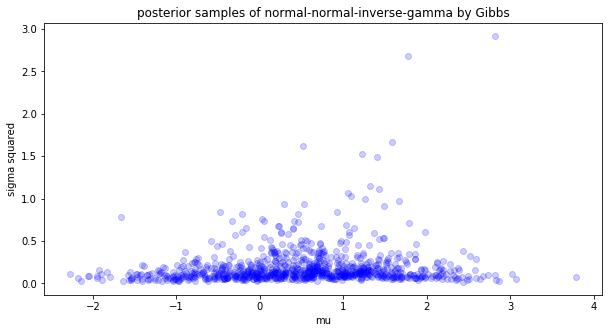

In [10]:
#plot posterior samples via gibbs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 100)
ax.scatter(posterior_samples[:, 0], posterior_samples[:, 1], color='blue', alpha=0.2)
ax.set_title('posterior samples of normal-normal-inverse-gamma by Gibbs')
ax.set_xlabel('mu')
ax.set_ylabel('sigma squared')
plt.show()   

# Summarizing Sampling

## Samplers for Simulating Random Variables
A ***sampler*** is a procedure for producing random numbers from a specific distribution $p(X)$. We've seen that we can build up samplers for sophisticated distributions, incrementally, starting from a sampler for a uniform distribution $U(0, 1)$.

1. **Linear Congruence Pseudo Random Number Generator:** simulates random numbers in $U(0, 1)$. 
  By translating and scaling we can simulate a random variable $U\sim U(a, b)$.
  
2. **Inverse CDF Sampling:** transforms random samples from a uniform distribution $U(0, 1)$ into samples from a univariate distribution $p(X)$ by using the inverse CDF of $X$. 
  
3. **Rejection Sampling:** find a proposal distribution $q(X)$ that is (1) easy to sample from and (2) approximates the target distribution $p(X)$. We then sample from $q$ and reject samples that are unlikely under $p$.
  
4. **Gibbs Sampling:** when complex multivariate distributions have easy conditional distributions $p(X_n | X_1, \ldots, X_{n-1}, X_{n+1}, \ldots, X_{N})$, we can obtain samples iteratively by updating the last sample from the conditionals, one coordinate at a time. *Eventually, these samples will be from $p(X)$*. This allows us to sample from the posterior of models with semi-conjugate priors.  

## How to Evaluate a Sampler

1. **Correctness:** Every sampler must come with a ***proof*** of correctness - that is, the numbers produced by the sampler have the distribution $p(X)$. Many intuitively sensible ways of sampling can fail to be correct.

  **Question:** Why isn't it sufficient to "histogram" the samples and check that they are distributed like $p(X)$?<br><br>

2. **Efficiency:** Every sampler must be analyzed for it's efficiency - that is, how many times the procedure must run before it accepts a sample. You should also be aware of how the efficiency is affected by the dimension of $X$.

  **Question:** How do inverse CDF and rejection compare in terms of efficiency?<br><br>
  
3. **Sufficiency of repetition:** Some samplers like Gibbs comes with the guarantee that if you repeat the procedure enough times (asymptotically), you will eventually be sampling from $p(X)$. But exactly how many times is enough?

## Why are We Sampling Again?

Recall that the primary objects of interest in a Bayesian model are the ***posterior distribution*** over parameters and the ***posterior predictive distribution*** over observations.

Evaluating the model, forming scientific hypothesis about the data and making predictions all require **sampling** from one of the two distributions.

When the prior is conjugate for the likelihood, the posterior pdf can be derived in closed form. Often, such a posterior is easy to sample from (using inverse CDF or rejection sampling). However, restricting ourselves to such simple likelihoods and priors limits our ability to model complex real-life data!

Our goal is to develop a set of different procedures that allow us to sample from arbitrary distributions. I.e. **samplers will make Bayesian inference more "generic", less "artisenal"**.

## What If We Want Posterior Point Estimates?

Posterior samples allow us to approximately compute posterior point estimates, for example, we can approximate the posterior mean as
$$
\mathbb{E}_{\theta|Y}[\theta] = \int_\Theta \theta\, p(\theta | Y)\,d\theta \approx \frac{1}{S}\sum_{s=1}^S \theta_s,\, \theta_s \sim p(\theta | Y)
$$

In fact, for any function $f$ of $\theta | Y$, we can estimate the expected vaue of $f$ by first sampling $S$ samples from the posterior $p(\theta | Y)$ and then compute the average value of $f$ on these samples:
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int_\Theta f(\theta)\, p(\theta | Y)\,d\theta \approx \frac{1}{S}\sum_{s=1}^S f(\theta_s),\, \theta_s \sim p(\theta | Y)
$$

**Question:** But is this estimate consistent? Unbiased? Of minimal variance?